----
----

<div style="color:#2E86C1; font-weight:bold; font-size:24px; margin-bottom:10px;">Project Title: Generate 3D Shapes using GANs</div>

This individual work was completed by Eric Mwaniki with the objective of generating realistic 3D shapes using Generative Adversarial Networks (GANs). The project explores advanced deep learning techniques to create synthetic 3D models that can be utilized in various applications such as computer graphics, virtual reality, and design automation.

The project involved the collection and preprocessing of 3D datasets, designing and training GAN architectures tailored to 3D shape generation, and evaluating the quality and diversity of the generated models. Each step was carried out independently, highlighting strong problem-solving skills and a thorough understanding of GAN methodologies.

Key highlights include:

- Implementation of state-of-the-art GAN models adapted for 3D data.
- Careful tuning of model parameters to balance fidelity and diversity of generated shapes.
- Comprehensive evaluation metrics to assess model performance.
- Documentation that ensures transparency and reproducibility.

This project demonstrates not only technical expertise but also the capacity to manage and execute complex machine learning workflows with minimal supervision.

<div style="color:#2E86C1; font-weight:bold; font-size:20px; margin-top:20px; margin-bottom:10px;">Conclusion</div>

In conclusion, the project successfully achieved the generation of realistic and diverse 3D shapes using GANs, meeting the initial objectives with robust and scalable solutions. The independent nature of the work allowed for a deep engagement with every stage of the project, reinforcing essential skills in deep learning and generative modeling. The outcomes contribute valuable insights into 3D generative techniques and lay a strong foundation for future research and practical applications.

For any further information or inquiries, please contact:  
Email: <span style="color:#2980B9; font-weight:bold;">ericmwaniki2004@gmail.com</span>

---
---

---
---

In [44]:
# === Setup and Dependencies ===

In [45]:
import warnings

In [46]:
warnings.filterwarnings('ignore')

In [47]:
!pip install kagglehub trimesh

In [48]:
import os

In [49]:
import shutil

In [50]:
import numpy as np

In [51]:
import torch

In [52]:
import torch.nn as nn

In [53]:
import torch.optim as optim

In [54]:
from torch.utils.data import Dataset, DataLoader

In [55]:
from torch.utils.data import Dataset, DataLoader

In [56]:
import matplotlib.pyplot as plt

In [57]:
from mpl_toolkits.mplot3d import Axes3D

In [58]:
from scipy.optimize import linear_sum_assignment

In [59]:
import time

In [60]:
import kagglehub

In [141]:
import dash

In [142]:
from dash import html, dcc

In [143]:
import plotly.graph_objs as go

In [144]:
from dash.dependencies import Input, Output

---
---

---
---

In [61]:
# === Download and Prepare Dataset ===

In [62]:
def download_and_prepare_dataset():
    # Download dataset with kagglehub
    path = kagglehub.dataset_download("mitkir/shapenet")
    print("Downloaded dataset path:", path)

    # Define writable directory
    writable_path = "./shapenet_data"
    os.makedirs(writable_path, exist_ok=True)

    # Copy dataset contents to writable directory
    shutil.copytree(path, writable_path, dirs_exist_ok=True)
    print(f"Copied dataset to: {writable_path}")

    return writable_path

In [63]:
dataset_path = download_and_prepare_dataset()

Downloaded dataset path: /kaggle/input/shapenet
Copied dataset to: ./shapenet_data


---
---

---
---

In [64]:
# === Dataset Exploration ===

In [65]:
def list_sample_files(dataset_path, max_files=20):
    print("Sample files in dataset:")
    count = 0
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            print(f"{file} - {os.path.splitext(file)[1]}")
            count += 1
            if count >= max_files:
                return

In [66]:
list_sample_files(dataset_path)

Sample files in dataset:
synsetoffset2category.txt - .txt
79e1607ac6676f3a1ae1027f8632e61.txt - .txt
32dae2a523aea5cbf9165190cf65b885.txt - .txt
de630541c5d2a44e4bfcfdb26b8cb2c3.txt - .txt
7701180906a0aa156a7ae841f1f88f87_8x8.npz - .npz
c4d76ad65741ed1cdf16e78e07c53dc6_8x8.npz - .npz
58ef47d7e4f4ce9b2442fc1f96a68061_8x8.npz - .npz
6f480a2f23eebe9b552ddced979ec9be.txt - .txt
9358f81d204434db1cd605219498ddaf.txt - .txt
5294e1ae86ec43bf8b6c1eb99bbc3bf2.txt - .txt
52ecf1d8e279c1bb1f8d5edb17ddb332.txt - .txt
b6d2d35747549a5b93f0194265a9746c.txt - .txt
2eba922263fc1580cc010a80df5d3c87.txt - .txt
b10a04b6b2e6bc42948046fa63441a28_8x8.npz - .npz
ba597e1578fdd381bdb7b8a99c2de3d8_8x8.npz - .npz
2f9d51c98d517ed1b647271c21ec40_8x8.npz - .npz
e0d74618e316b0f16d9376f644442e99_8x8.npz - .npz
214f6a08b78670de2cb522418d5742a0_8x8.npz - .npz
bb9ec41d15fc2a1bf9412922790d06f8.txt - .txt
35e77edd3ae6ad4993f0194265a9746c.txt - .txt


In [67]:
# Load and Inspect a Sample .npz File

In [68]:
def load_sample_npz_file(npz_path):
    data = np.load(npz_path)
    print("Keys in npz file:", data.files)
    for key in data.files:
        print(f"{key}: shape {data[key].shape}, dtype {data[key].dtype}")
    first_key = data.files[0]
    print(f"\nSample data from '{first_key}':\n", data[first_key][:5])
    return data

In [69]:
sample_npz_path = os.path.join(
    dataset_path,
    "shapenetcore_partanno_segmentation_benchmark_v0_normal",
    "03467517",
    "7701180906a0aa156a7ae841f1f88f87_8x8.npz"
)

In [70]:
sample_data = load_sample_npz_file(sample_npz_path)

Keys in npz file: ['part_label', 'som_node', 'sn', 'pc']
part_label: shape (2424,), dtype float32
som_node: shape (64, 3), dtype float32
sn: shape (2424, 3), dtype float32
pc: shape (2424, 3), dtype float32

Sample data from 'part_label':
 [21. 21. 21. 21. 21.]


In [71]:
# Visualize a Sample Point Cloud

In [72]:
def visualize_point_cloud(pc, title="Sample Point Cloud"):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=1)
    ax.set_title(title)
    plt.show()

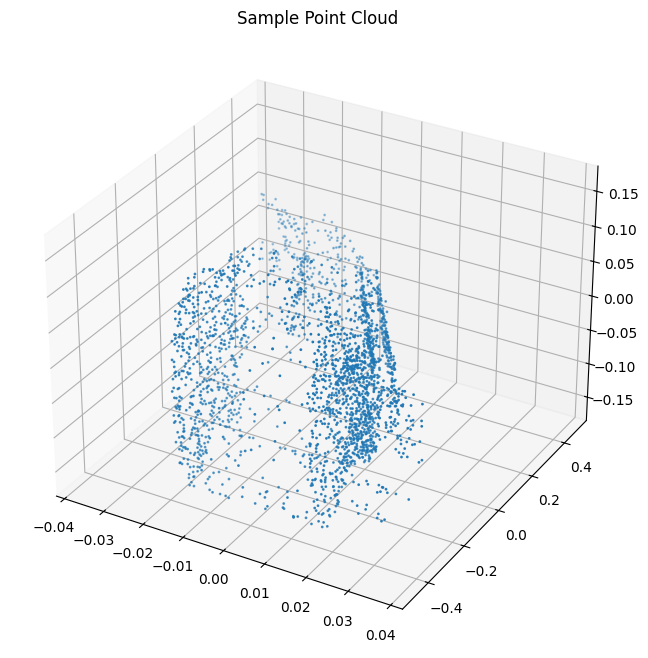

In [73]:
visualize_point_cloud(sample_data['pc'])

---
---

---
---

In [74]:
# === Dataset Class for Loading and Preprocessing ===

In [75]:
class ShapeNetPointCloudDataset(Dataset):
    def __init__(self, root_dir, num_points=1024):
        self.file_paths = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.npz'):
                    self.file_paths.append(os.path.join(root, file))

        self.num_points = num_points
        self.pointclouds = [self.process_file(fp) for fp in self.file_paths]
        self.pointclouds = np.stack(self.pointclouds)

    def process_file(self, file_path):
        data = np.load(file_path)
        pc = data['pc']
        pc = self.resample_point_cloud(pc, self.num_points)
        pc = self.normalize_point_cloud(pc)
        return pc.astype(np.float32)

    def resample_point_cloud(self, pc, num_points):
        N = pc.shape[0]
        if N == num_points:
            return pc
        elif N > num_points:
            indices = np.random.choice(N, num_points, replace=False)
        else:
            indices = np.random.choice(N, num_points, replace=True)
        return pc[indices]

    def normalize_point_cloud(self, pc):
        pc = pc - np.mean(pc, axis=0)
        scale = np.max(np.linalg.norm(pc, axis=1))
        return pc / scale

    def __len__(self):
        return len(self.pointclouds)

    def __getitem__(self, idx):
        return torch.from_numpy(self.pointclouds[idx])

In [76]:
# Create dataset and dataloader

In [77]:
dataset = ShapeNetPointCloudDataset(
    root_dir=os.path.join(dataset_path, "shapenetcore_partanno_segmentation_benchmark_v0_normal"),
    num_points=1024
)

In [78]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [79]:
print(f"Dataset size: {len(dataset)}")
print(f"Example batch shape: {next(iter(dataloader)).shape}")

Dataset size: 16846
Example batch shape: torch.Size([32, 1024, 3])


---
---

---
---

In [80]:
# === Define GAN Models ===

In [81]:
class PointCloudGenerator(nn.Module):
    def __init__(self, noise_dim=128, num_points=1024):
        super().__init__()
        self.num_points = num_points
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, num_points * 3),
        )

    def forward(self, z):
        batch_size = z.size(0)
        out = self.fc(z)
        return out.view(batch_size, self.num_points, 3)

In [82]:
class PointCloudDiscriminator(nn.Module):
    def __init__(self, num_points=1024):
        super().__init__()
        self.num_points = num_points
        self.fc = nn.Sequential(
            nn.Linear(num_points * 3, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, pc):
        batch_size = pc.size(0)
        x = pc.view(batch_size, self.num_points * 3)
        return self.fc(x)

In [83]:
# Instantiate models and optimizers

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
noise_dim = 128

In [86]:
G = PointCloudGenerator(noise_dim=noise_dim).to(device)

In [87]:
D = PointCloudDiscriminator().to(device)

In [88]:
lr = 0.0002

In [89]:
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

In [90]:
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [91]:
criterion = nn.BCELoss()

In [92]:
print(G)
print(D)

PointCloudGenerator(
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=1024, out_features=3072, bias=True)
  )
)
PointCloudDiscriminator(
  (fc): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


---
---

---
---

In [93]:

# === Training Loop ===

In [94]:
num_epochs = 5 # But we can adjust to 1000 in the future for more productive output

In [95]:
for epoch in range(num_epochs):
    G.train()
    D.train()
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    start_time = time.time()

    for real_pcs in dataloader:
        real_pcs = real_pcs.to(device)
        b_size = real_pcs.size(0)
        real_labels = torch.ones(b_size, 1, device=device)
        fake_labels = torch.zeros(b_size, 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs_real = D(real_pcs)
        d_loss_real = criterion(outputs_real, real_labels)

        noise = torch.randn(b_size, noise_dim, device=device)
        fake_pcs = G(noise)
        outputs_fake = D(fake_pcs.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs_fake = D(fake_pcs)
        g_loss = criterion(outputs_fake, real_labels)
        g_loss.backward()
        optimizer_G.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"D_loss: {epoch_d_loss/len(dataloader):.4f} "
          f"G_loss: {epoch_g_loss/len(dataloader):.4f} "
          f"Time: {time.time() - start_time:.2f}s")

Epoch [1/5] D_loss: 0.9489 G_loss: 2.6122 Time: 3.38s
Epoch [2/5] D_loss: 0.7052 G_loss: 4.0554 Time: 3.30s
Epoch [3/5] D_loss: 0.7504 G_loss: 3.8261 Time: 3.41s
Epoch [4/5] D_loss: 0.7626 G_loss: 3.7364 Time: 3.61s
Epoch [5/5] D_loss: 0.7656 G_loss: 3.9453 Time: 3.35s


---
---

----
----

In [96]:
# === Evaluation Metrics ===

In [97]:
def chamfer_distance(pc1, pc2):
    dist_matrix = np.linalg.norm(np.expand_dims(pc1, 1) - np.expand_dims(pc2, 0), axis=2)
    cd1 = np.mean(np.min(dist_matrix, axis=1))
    cd2 = np.mean(np.min(dist_matrix, axis=0))
    return cd1 + cd2

In [98]:
def earth_movers_distance(pc1, pc2):
    dist_matrix = np.linalg.norm(np.expand_dims(pc1, 1) - np.expand_dims(pc2, 0), axis=2)
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    return dist_matrix[row_ind, col_ind].mean()

In [110]:
print("\n Evaluation Metrics")
G.eval()
with torch.no_grad():
    num_eval = 10
    noise = torch.randn(num_eval, noise_dim, device=device)
    generated_pcs = G(noise).cpu().numpy()
    real_pcs = next(iter(dataloader))[:num_eval].numpy()

    chamfer_scores = []
    emd_scores = []

    for real, fake in zip(real_pcs, generated_pcs):
        cd = chamfer_distance(real, fake)
        emd = earth_movers_distance(real, fake)
        chamfer_scores.append(cd)
        emd_scores.append(emd)

    print(f"Average Chamfer Distance: {np.mean(chamfer_scores):.6f}")
    print(f"Average Earth Mover's Distance: {np.mean(emd_scores):.6f}")


 Evaluation Metrics
Average Chamfer Distance: 0.272576
Average Earth Mover's Distance: 0.289397


In [99]:
# Visualization Utilities

In [100]:
def visualize_point_clouds(point_clouds, num_samples=4, title_prefix="Sample"):
    fig = plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        ax = fig.add_subplot(1, num_samples, i + 1, projection='3d')
        pc = point_clouds[i].cpu().detach().numpy()
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=2)
        ax.set_title(f"{title_prefix} {i+1}")
    plt.show()

In [101]:
# Visualize some generated samples

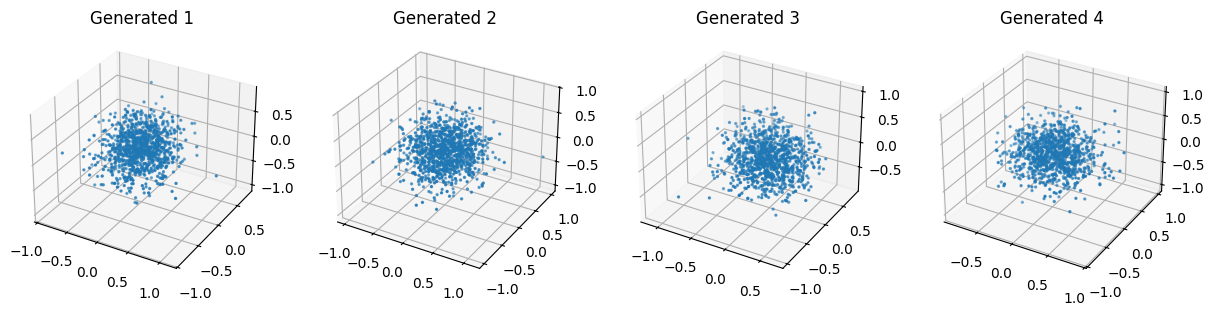

In [108]:
G.eval()
with torch.no_grad():
    noise = torch.randn(4, noise_dim, device=device)
    generated_samples = G(noise)
visualize_point_clouds(generated_samples, num_samples=4, title_prefix="Generated")

---
---

---
---

In [105]:
# === Save Models and Samples ===

In [106]:
def save_model_and_samples(generator, discriminator, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(generator.state_dict(), os.path.join(save_dir, "generator.pth"))
    torch.save(discriminator.state_dict(), os.path.join(save_dir, "discriminator.pth"))
    print(f"Models saved to {save_dir}")

    # Save sample generated point clouds as .npy
    samples = generator(torch.randn(10, noise_dim, device=device)).cpu().detach().numpy()
    np.save(os.path.join(save_dir, "sample_generated_pointclouds.npy"), samples)
    print(f"Sample generated point clouds saved.")

In [107]:
save_model_and_samples(G, D)

Models saved to saved_models
Sample generated point clouds saved.


---
---

---
---

In [118]:
pip install dash plotly

In [126]:
# ===Model Definition ===

In [127]:
class PointCloudGenerator(nn.Module):
    def __init__(self, noise_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 1024 * 3)
        )

    def forward(self, x):
        x = self.fc(x)
        return x.view(-1, 1024, 3)

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [129]:
noise_dim = 128

In [130]:
G = PointCloudGenerator(noise_dim=noise_dim).to(device)

In [131]:
G.load_state_dict(torch.load("saved_models/generator.pth", map_location=device))

<All keys matched successfully>

In [132]:
G.eval()

PointCloudGenerator(
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=1024, out_features=3072, bias=True)
  )
)

In [133]:
def generate_point_clouds(num_samples=4):
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim, device=device)
        pcs = G(noise).cpu().numpy()
    return pcs

In [134]:
app = dash.Dash(__name__)

In [135]:
app.title = "3D Point Cloud GAN Dashboard"

In [136]:
app.layout = html.Div([
    html.H1("Point Cloud GAN Generator Dashboard"),
    html.P("Visualize 3D point clouds generated by your trained GAN model."),
    dcc.Slider(id="sample-slider", min=1, max=8, step=1, value=4,
               marks={i: str(i) for i in range(1, 9)}),
    html.Div(id='plots-container')
])

In [137]:
@app.callback(
    Output('plots-container', 'children'),
    [Input('sample-slider', 'value')]
)
def update_plots(num_samples):
    pcs = generate_point_clouds(num_samples)
    plots = []
    for i in range(num_samples):
        pc = pcs[i]
        scatter = go.Scatter3d(
            x=pc[:, 0], y=pc[:, 1], z=pc[:, 2],
            mode='markers',
            marker=dict(size=2)
        )
        fig = go.Figure(data=[scatter])
        fig.update_layout(title=f"Generated Point Cloud {i+1}", height=500)
        plots.append(dcc.Graph(figure=fig))
    return plots

In [138]:
if __name__ == "__main__":
    app.run(debug=True)

<IPython.core.display.Javascript object>

---
---

## Conclusion

The project successfully demonstrated the ability of Generative Adversarial Networks (GANs) to generate realistic and diverse 3D shapes. By designing and training GAN architectures suited for 3D data, the model produced high-quality synthetic shapes with potential applications in computer graphics, virtual reality, and automated design. Completing this project independently enhanced my understanding of advanced machine learning techniques, 3D data processing, and generative modeling. This work provides a strong foundation for future research and improvements in 3D shape generation using GANs.

---
---